In [61]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
from skimage.filters import try_all_threshold, threshold_isodata, threshold_minimum, threshold_otsu

In [62]:
def FluCount (Filename = '14251.5_3(2).jpg', Test = False, QuickCheck = False, Channel = 'G'):
    # This function count seeds in fluorescent images
    # The default Filename is for testing 
    # 'Test' allows you to check all different threshold methods, normally used for individual images
    # 'QuickCheck' allows you to check the binary images current method ('minimum' in this case), 
    # normally used for checking all images.
    # 'Channel' defines whether to use Green or Red channels for GFP and RFP seeds
    
    
    image = io.imread(Filename)
    
    
    #-----------------------------------Split channels----------------------------------------------
    
    if Channel == 'G':
        # Change to grayscale according to green or red channel
        green_image = image.copy()
        green_image[:,:,0] = 0
        green_image[:,:,2] = 0
        gray_image = rgb2gray(green_image)
        
    else:
        red_image = image.copy()
        red_image[:,:,1] = 0
        red_image[:,:,2] = 0
        gray_image = rgb2gray(red_image)
    
    # Set threshold to get binary images (for all fluorescent seeds)
    
    thresh = threshold_otsu(gray_image)
    binary = gray_image > thresh
    
    if QuickCheck == 1:
        plt.figure()
        plt.imshow(binary)
        plt.title(Filename + 'Fluorescent seeds')
        return
    
    # Label regions
    bw = closing(binary, square(3)) 
    cleared = clear_border(bw) #ignore all the seeds at the edge of the image
    label_image = label(cleared)
    seed = 0
    cali_seed = 0
    cali_area = 0
    large_area = 0

    for region in regionprops(label_image):
        if 400 < region.area < 700 :
            cali_seed = cali_seed + 1
            cali_area = cali_area + region.area
        if 5 < region.area < 700:
            seed = seed + 1
        elif region.area > 700:
            large_area = large_area + region.area

    ave_area = cali_area / cali_seed
    large_seed = large_area / ave_area
    seed = seed + large_seed

    #------------------------------------------------------------------------------------
    #Now for the bright seeds (overwrite the above images)
    
    # Set threshold to get binary images (for bright seeds)
    
    
    seed_Bright = 0
    try:
        thresh = threshold_minimum(gray_image)
    except:
        print('Problems with setting the threshold for counting bright seeds: ' + str(Filename)) 
        if Test == True:
            try_all_threshold(gray_image)
    else:
        binary = gray_image > thresh
        
        if QuickCheck == 2:
            plt.figure()
            plt.imshow(binary)
            plt.title(Filename + 'Bright seeds')
            return
        
        # Label regions
        bw = closing(binary, square(3)) 
        cleared = clear_border(bw) #ignore all the seeds at the edge of the image
        label_image = label(cleared)

        seed_Bright = 0
        cali_seed_Bright = 0
        cali_area_Bright = 0     
        large_area_Bright = 0

        for region in regionprops(label_image):
            if 400 < region.area < 700 :
                cali_seed_Bright = cali_seed_Bright + 1
                cali_area_Bright = cali_area_Bright + region.area
            if 5 < region.area < 700:
                seed_Bright = seed_Bright + 1
            elif region.area > 700:
                large_area_Bright = large_area_Bright + region.area

        if cali_seed_Bright <20:
            ave_area_Bright = ave_area
        else:
            ave_area_Bright = cali_area_Bright / cali_seed_Bright
        large_seed_Bright = large_area_Bright / ave_area_Bright
        seed_Bright = seed_Bright + large_seed_Bright
    
    return int(seed), int(seed_Bright)

    

OutFlu = []
for file in glob.glob('*).jpg'):
    dic = {'File':file, 'Seed':FluCount(file)[0], 'Bright_Seed':FluCount(file)[1]}
    OutFlu.append(dic)
    
pd.DataFrame(OutFlu, columns=OutFlu[0].keys())


## Combine

FileList = df['File']

ConsList = []
for i in FileList:
    ConsList.append(i.split('(')[0])
ConsList = list(set(ConsList))


CleanDf = []
for i in ConsList:
    sub = df[df['File'].str.match(str(i))]
    dic = {'Construct' : str(i), 'Total Seed': sub['Seed'].sum(), 
           'Total Bright Seed': sub['Bright_Seed'].sum()}
    CleanDf.append(dic)
    
pd.DataFrame(CleanDf, columns=CleanDf[0].keys())

    

def Combine(df):
    # This function take the results from FluCount() or BFCount and combine the seed counts of one constrcuts 
    # which are in different images
    
   
    FileList = df['File']

    ConsList = [] #creat a list of constructs
    for i in FileList:
        ConsList.append(i.split('(')[0])
    ConsList = list(set(ConsList))


    CleanDf = []
    for i in ConsList:
        sub = df[df['File'].str.match(str(i))]
        dic = {'Construct' : str(i), 'Total fluorescent Seed': sub['Seed'].sum(), 
               'Bright Seed': sub['Bright_Seed'].sum()}
        CleanDf.append(dic)
        
    pd.DataFrame(CleanDf, columns=CleanDf[0].keys())



## Counting Funtion

In [63]:
def Give_Me_FluCounts(File = '*).jpg', QuickCheck = False, Test = False):
    # This function takes a group of files as input, calculate the fluorescent seeds and combine the number per 
    # consrtucts. Output is a .csv file
    # I suggest you first run a quick check of the binary images you create from thresholding methods, to do this,
    # use 'QuickCheck = 1' to check all fluorescent seeds, use 'QuickCheck = 2' to check all bright seeds
    
    if QuickCheck != False: 
        for file in glob.glob(File):
            FluCount(file, QuickCheck = True)
        return
    
    OutFlu = []
    for file in glob.glob(File):
        dic = {'File':file, 'Seed':FluCount(file,Test = False)[0], 'Bright_Seed':FluCount(file, Test)[1]}
        OutFlu.append(dic)

    df = pd.DataFrame(OutFlu, columns=OutFlu[0].keys())

    FileList = df['File']

    ConsList = []
    for i in FileList:
        ConsList.append(i.split('(')[0])
    ConsList = list(set(ConsList))

    CleanDf = []
    for i in ConsList:
        sub = df[df['File'].str.match(str(i))]
        dic = {'Construct' : str(i), 'Total fluorescent Seed': sub['Seed'].sum(), 
               'Bright Seed': sub['Bright_Seed'].sum()}
        CleanDf.append(dic)

    Counts = pd.DataFrame(CleanDf, columns=CleanDf[0].keys())
    display(Counts)
    
    df.to_csv('Counts_Flu_Individual.csv')
    Counts.to_csv('Counts_Flu.csv')

   

/home/zd101/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



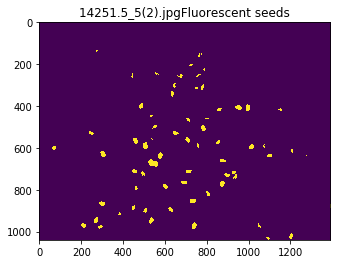

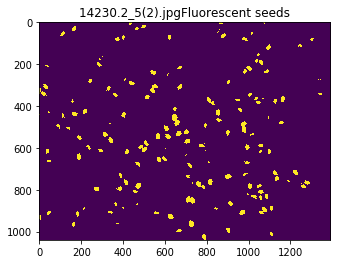

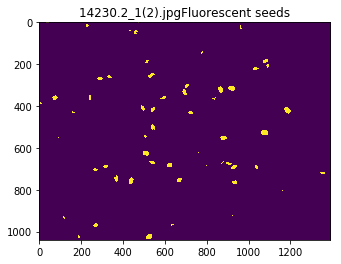

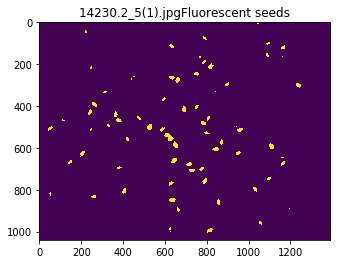

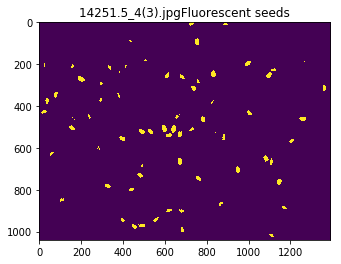

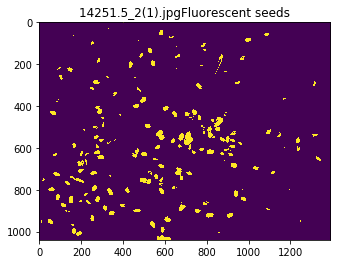

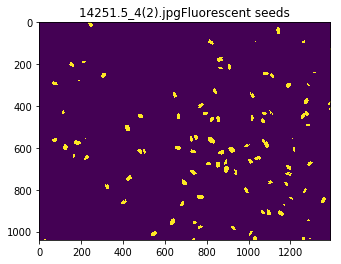

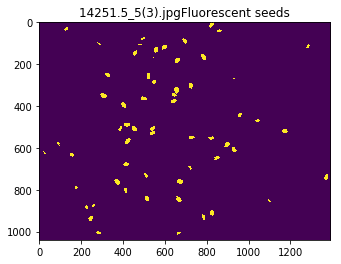

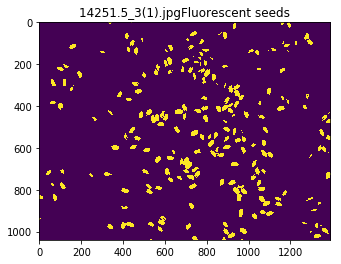

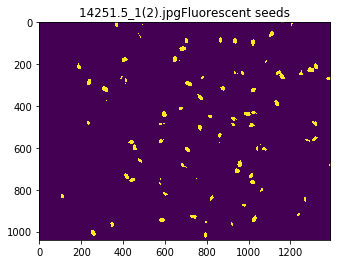

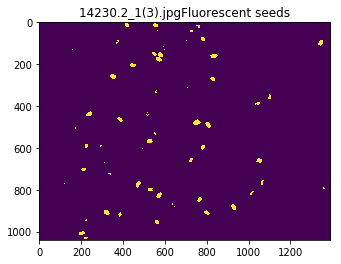

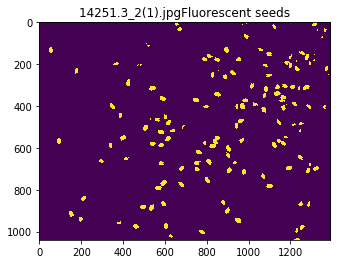

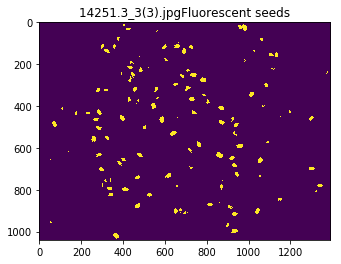

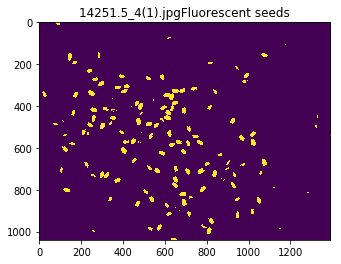

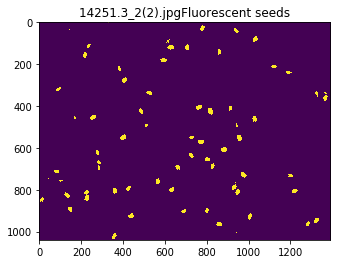

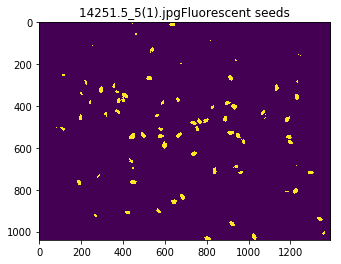

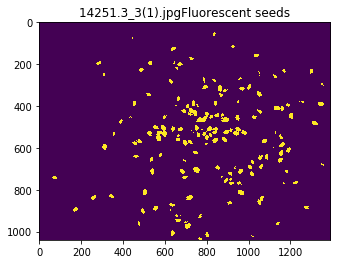

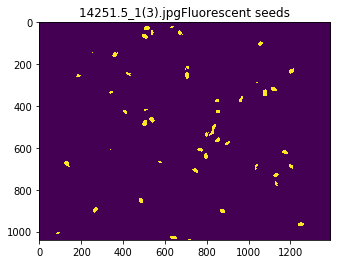

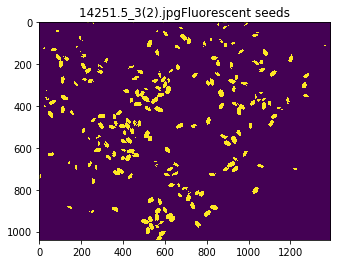

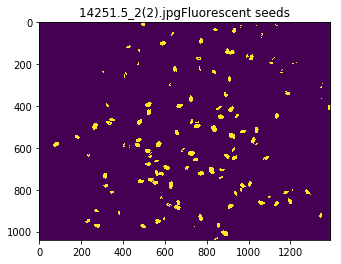

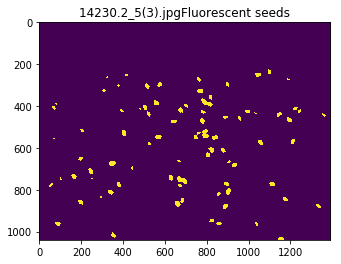

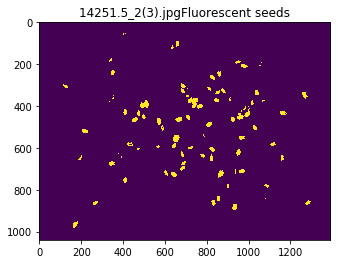

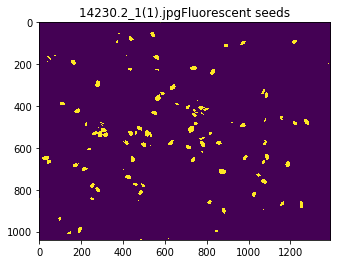

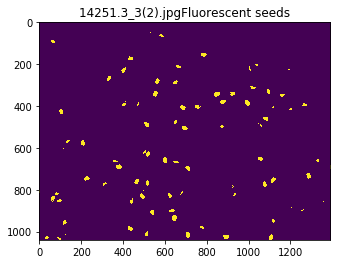

In [64]:
Give_Me_FluCounts(QuickCheck = 1)

In [52]:
Give_Me_FluCounts()

Problems with setting the threshold for counting bright seeds: 14251.5_3(1).jpg
Problems with setting the threshold for counting bright seeds: 14251.5_3(1).jpg
Problems with setting the threshold for counting bright seeds: 14251.5_4(1).jpg
Problems with setting the threshold for counting bright seeds: 14251.5_4(1).jpg


,Construct,Total Seed,Total Bright Seed
0,14230.2_5,312,3
1,14251.5_4,306,3
2,14251.3_3,377,39
3,14251.5_3,435,77
4,14251.3_2,207,6
5,14251.5_5,201,28
6,14251.5_1,140,34
7,14251.5_2,398,9
8,14230.2_1,219,19


## Draft

plt.imshow(io.imread(''))

glob.glob('*).jpg')

In [54]:
FluCount('14251.5_3(1).jpg')

Problems with setting the threshold for counting bright seeds: 14251.5_3(1).jpg


(222, 0)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 576x360 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df15506a0>,
       dtype=object))

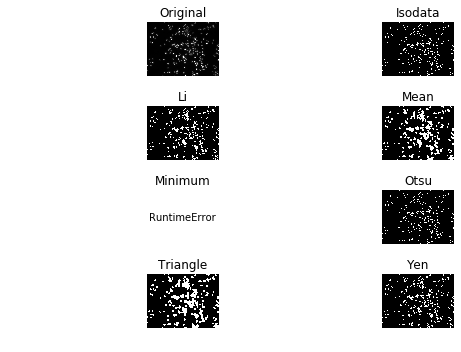

In [60]:
image = io.imread('14251.5_3(1).jpg')

green_image = image.copy()

# Change to grayscale according to green channel
green_image[:,:,0] = 0
green_image[:,:,2] = 0
gray_image = rgb2gray(green_image)

# Set threshold to get binary images (for all fluorescent seeds)

try_all_threshold(gray_image)


In [ ]:
plt.imshow(binary)